# Speaker Recognition using GMMs
This workbook I experiement with:
* Implementing a speaker recognition algorithm using GMMs
* Practising with MFCC features to characterise speakers voice.

In [1]:
import numpy as np
import librosa
from pydub import AudioSegment
from pydub.utils import mediainfo
from sklearn import preprocessing

In the SpeakerData folder, there are two folders: Train and Test containing training and test speech files
respectively. Each Train/Test folder includes twenty-five (25) sub-folders containing speech sounds made by 25
different speakers. There are ten (10) speech files per speaker, in which three (3) files are used for training and
the remainders are used for testing. No file is used for both training and testing.

# 1. Building GMMs with MFCC Features
The code below defines some MFCC feature extraction functionsfrom audio data and builds GMMs for all the speakers in
the SpeakerData dataset using MFCC features.

In [2]:
def mfcc_extraction(audio_filename,
                    hop_duration,
                    num_mfcc
                   ):
    speech = AudioSegment.from_wav(audio_filename)
    samples = speech.get_array_of_samples()
    sampling_rate = speech.frame_rate

    mfcc = librosa.feature.mfcc(np.float32(samples),
                                sr = sampling_rate,
                                hop_length = int(sampling_rate * hop_duration),
                                n_mfcc = num_mfcc)
    return mfcc.T

In [3]:
from sklearn.mixture import GaussianMixture

In [4]:
def learningGMM(features,
                n_components,
                max_iter
               ):
    gmm = GaussianMixture(n_components = n_components, max_iter = max_iter, random_state=16)
    gmm.fit(features)
    return gmm

Get a list of the speaker labels fromt he folder structure.

In [5]:
import os

path = './resources/SpeakerData/'
speakers = os.listdir(path + 'Train/')
print(speakers)

['Anthony', 'AppleEater', 'Ara', 'Argail', 'Ariyan', 'Arjuan', 'Artem', 'Arthur', 'Artk', 'Arun', 'Arvala', 'Asalkeld', 'Asladic', 'Asp', 'Azmisov', 'B', 'Bachroxx', 'Bae', 'Bahoke', 'Bareford', 'Bart', 'Bassel', 'Beady', 'Beez', 'BelmontGuy']


In [6]:
from sklearn import preprocessing

In [7]:
mfcc_all_speakers = []
hop_duration = 0.015
num_mfcc = 12

Get the MFCC extracts for each speaker in the training set.

In [8]:
for s in speakers:
    sub_path = path + 'Train/' + s + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    mfcc_one_speaker = np.asarray(())
    for fn in sub_file_names:
        mfcc_one_file = mfcc_extraction(fn, hop_duration, num_mfcc)
        if mfcc_one_speaker.size == 0:
            mfcc_one_speaker = mfcc_one_file
        else:
            mfcc_one_speaker = np.vstack((mfcc_one_speaker, mfcc_one_file))
    mfcc_all_speakers.append(mfcc_one_speaker)

Get the MFCC extracts for each speaker in the test set.

In [26]:
y_true = []
test_files = []

for s in speakers:
    sub_path = path + 'Test/' + s + '/'
    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
    y = [s for f in os.listdir(sub_path)]
    y_true += y 
    test_files += sub_file_names

Create a folder to save the training features for re-use

In [52]:
if not os.path.exists('./TrainingFeatures/'):
    os.makedirs('./TrainingFeatures/')

In [10]:
import pickle

for i in range(0, len(speakers)):
    with open('./TrainingFeatures/' + speakers[i] + '_mfcc.fea','wb') as f:
        pickle.dump(mfcc_all_speakers[i], f)

Train the Gaussian Mixture Model (GMM).

In [11]:
n_components = 5
max_iter = 50

gmms = []

for i in range(0, len(speakers)):
    gmm = learningGMM(mfcc_all_speakers[i],
                      n_components,
                      max_iter)
    gmms.append(gmm)

Save the models to disk for re-use.

In [53]:
if not os.path.exists('./Models/'):
    os.makedirs('./Models/')

In [12]:
for i in range(len(speakers)):
    with open('./Models/' + speakers[i] + '.gmm', 'wb') as f:
        pickle.dump(gmms[i], f)

# 2. Speaker Recognition using GMMs

In [13]:
gmms = []
for i in range(len(speakers)):
    with open('./Models/' + speakers[i] + '.gmm', 'rb') as f:
        gmm = pickle.load(f)
        gmms.append(gmm)

In [15]:
def speaker_recognition(audio_file_name, gmms, speakers):
    """Takes an audio file path, a list of GMM's and a list of
    Speakers and returns the predicted speaker."""
    
    f = mfcc_extraction(audio_file_name, hop_duration, num_mfcc)

    scores = []

    for i in range(len(gmms)):
        scores.append(gmms[i].score(f))
    speaker_id = scores.index(max(scores))
    speakers[speaker_id]

    return speakers[speaker_id]

## Inference on test set

In this section I performed test set inference on the GMM models. As I had 1 model per speaker, I defined a speaker_recognition() function in python to help run test set inference. The speaker_recognition() function performed the following steps:
1.	Ran mfcc_extraction() function on the input file to get the MFCC features.
2.	Looped over all GMM models passing in the MFCC features and recording the score returned from the gmm.score() method.
3.	Determined the max score and the index number.
4.	Returned the name of the predicted speaker.

In [45]:
y_preds = [speaker_recognition(f, gmms, speakers) for f in test_files]

Score and plot the confusion matrix and classification report for the GMM.

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """ Adapted from blog post: https://deeplizard.com/learn/video/0LhiS6yu2qQ"""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.figure(figsize=(18,18))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        fmt = '.1%'
    else:
        fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
print(classification_report(y_true, y_preds, digits=3))

              precision    recall  f1-score   support

     Anthony      1.000     0.143     0.250         7
  AppleEater      1.000     1.000     1.000         7
         Ara      1.000     1.000     1.000         7
      Argail      1.000     1.000     1.000         7
      Ariyan      1.000     1.000     1.000         7
      Arjuan      1.000     1.000     1.000         7
       Artem      1.000     1.000     1.000         7
      Arthur      0.438     1.000     0.609         7
        Artk      1.000     1.000     1.000         7
        Arun      1.000     1.000     1.000         7
      Arvala      1.000     1.000     1.000         7
    Asalkeld      1.000     1.000     1.000         7
     Asladic      1.000     1.000     1.000         7
         Asp      1.000     1.000     1.000         7
     Azmisov      1.000     1.000     1.000         7
           B      0.636     1.000     0.778         7
    Bachroxx      1.000     1.000     1.000         7
         Bae      1.000    

Normalized confusion matrix


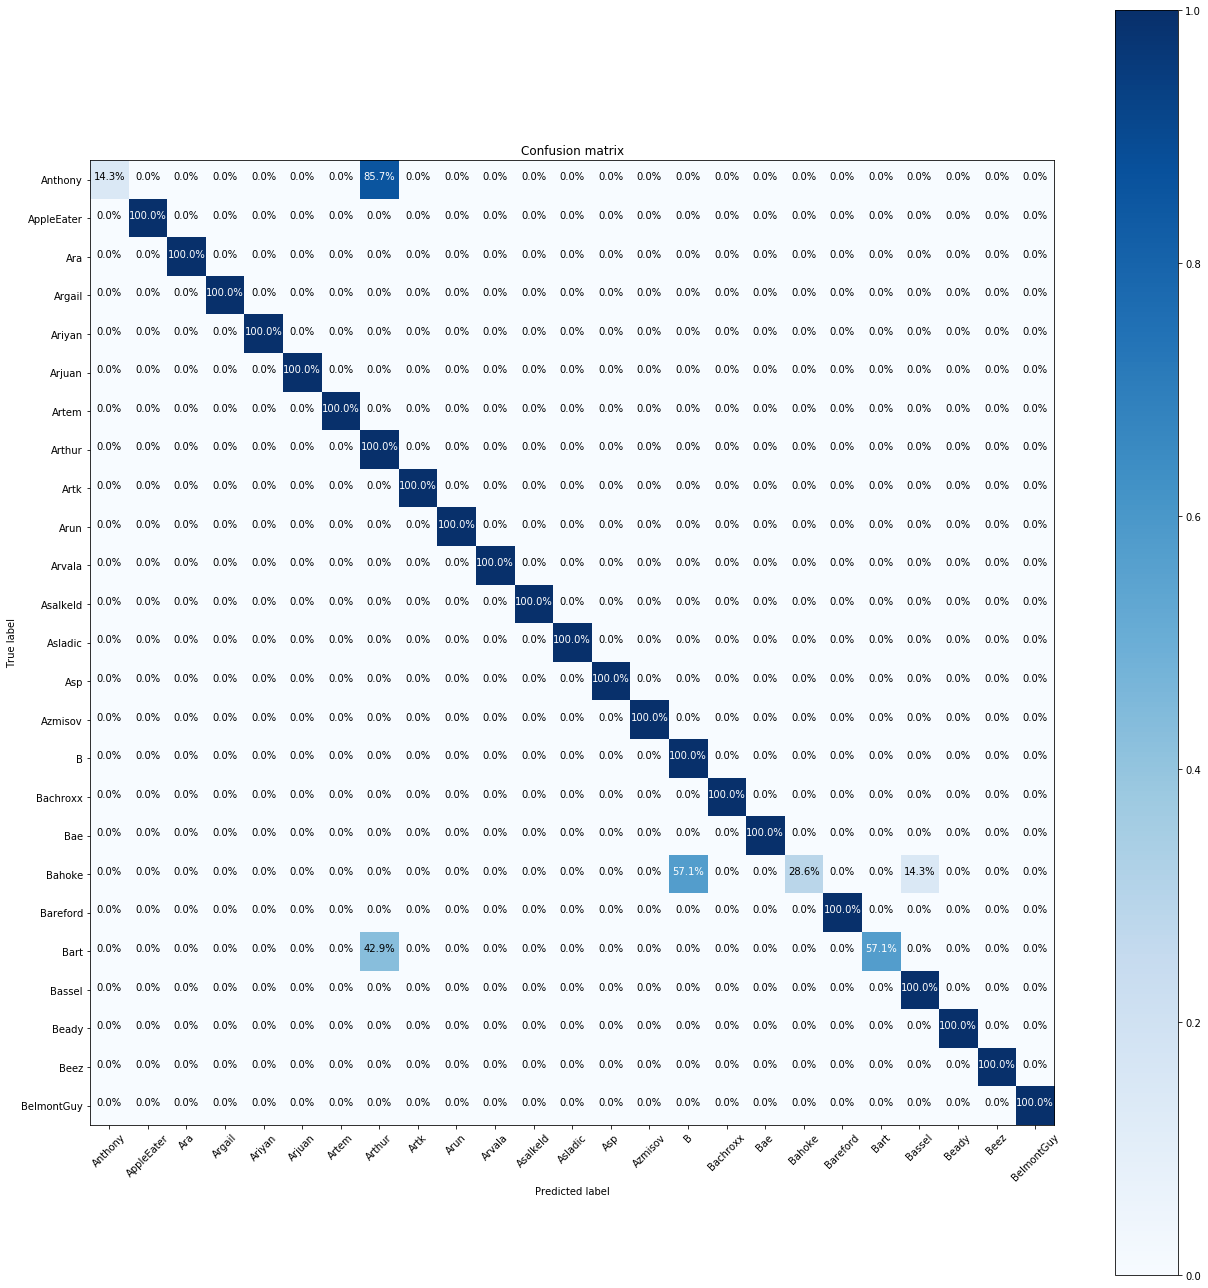

In [60]:
cm = confusion_matrix(y_true, y_preds, normalize='true')
plot_confusion_matrix(cm, speakers, normalize=True)
plt.savefig('gmm_confusion_matrix.png')

## Results
A test set accuracy of 92% was achieved. Surprisingly, the precision and recall for majority of speakers was perfect This can be seen visually in the confusion matrix in image 1. The complete scores can be seen in table 1.  
Overall, The Gaussian Mixture Models method for speaker recognition performed exceptionally well especially considering the number of classes in the dataset
